## Problem Statement
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. **The aim of this data science project is to build a predictive model and find out the sales of each product at a particular store.**
Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.
The data has missing values as some stores do not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

### Table of contents:

**1. Hypothesis Generation\
2. Loading Packages and Data\
3. Data Structure and Content\
4. Univariate EDA\
5. Bivariate EDA\
6. Data preprocessing\
7. Modeling\
8. Conclusion**

### Data
 
| Attributes | Represntation|
| -------- | ---------- |
| Item_Identifier| Unique product ID|
| Item_Weight| Weight of product | 
| Item_Fat_Content| Whether the product is low fat or regular |
| Item_Visibility | The % of total display area of all products in a store allocated to the particular product |
| Item_Type | The category to which the product belongs |
| Item_MRP | Maximum Retail Price (list price) of the product |
| Outlet_Identifier | Unique store ID |
| Outlet_Establishment_Year | The year in which store was established |
| Outlet_Size | The size of the store in terms of ground area covered |
| Outlet_Location_Type | The type of city in which the store is located |
| Outlet_Type | Whether the outlet is just a grocery store or some sort of supermarket |
| Item_Outlet_Sales | Sales of the product in the particulat store. This is the outcome variable to be predicted. |


## 1. Hypothesis Generation:

**Store location affects product sales:** Products sold in stores located in urban areas may have higher sales compared to those sold in rural areas due to higher population density and more foot traffic.

**Product placement affects sales:** Products placed at eye-level on shelves may sell more compared to those placed on the bottom or top shelves.

**Product advertising affects sales:** Products that are advertised through in-store displays or promotions may have higher sales compared to those that are not.

**Product pricing affects sales:** Products that are priced lower than competitors may have higher sales compared to those that are priced higher.

**Seasonal trends affect sales:** Products that are in high demand during certain seasons

**Product quality affects sales:** Products with higher quality or better packaging may have higher sales compared to those with lower quality or less attractive packaging.

## 2. Loading Packages and Data

In [ ]:
!pip install xgboost

In [6]:
!pip install joblib

In [101]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

# scores
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 

# save models
import joblib

In [102]:
data_train = pd.read_csv('9961_14084_bundle_archive/Train.csv')

In [103]:
data_test = pd.read_csv('9961_14084_bundle_archive/Test.csv')

In [104]:
data_train.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


## 3. Data Structure and Content

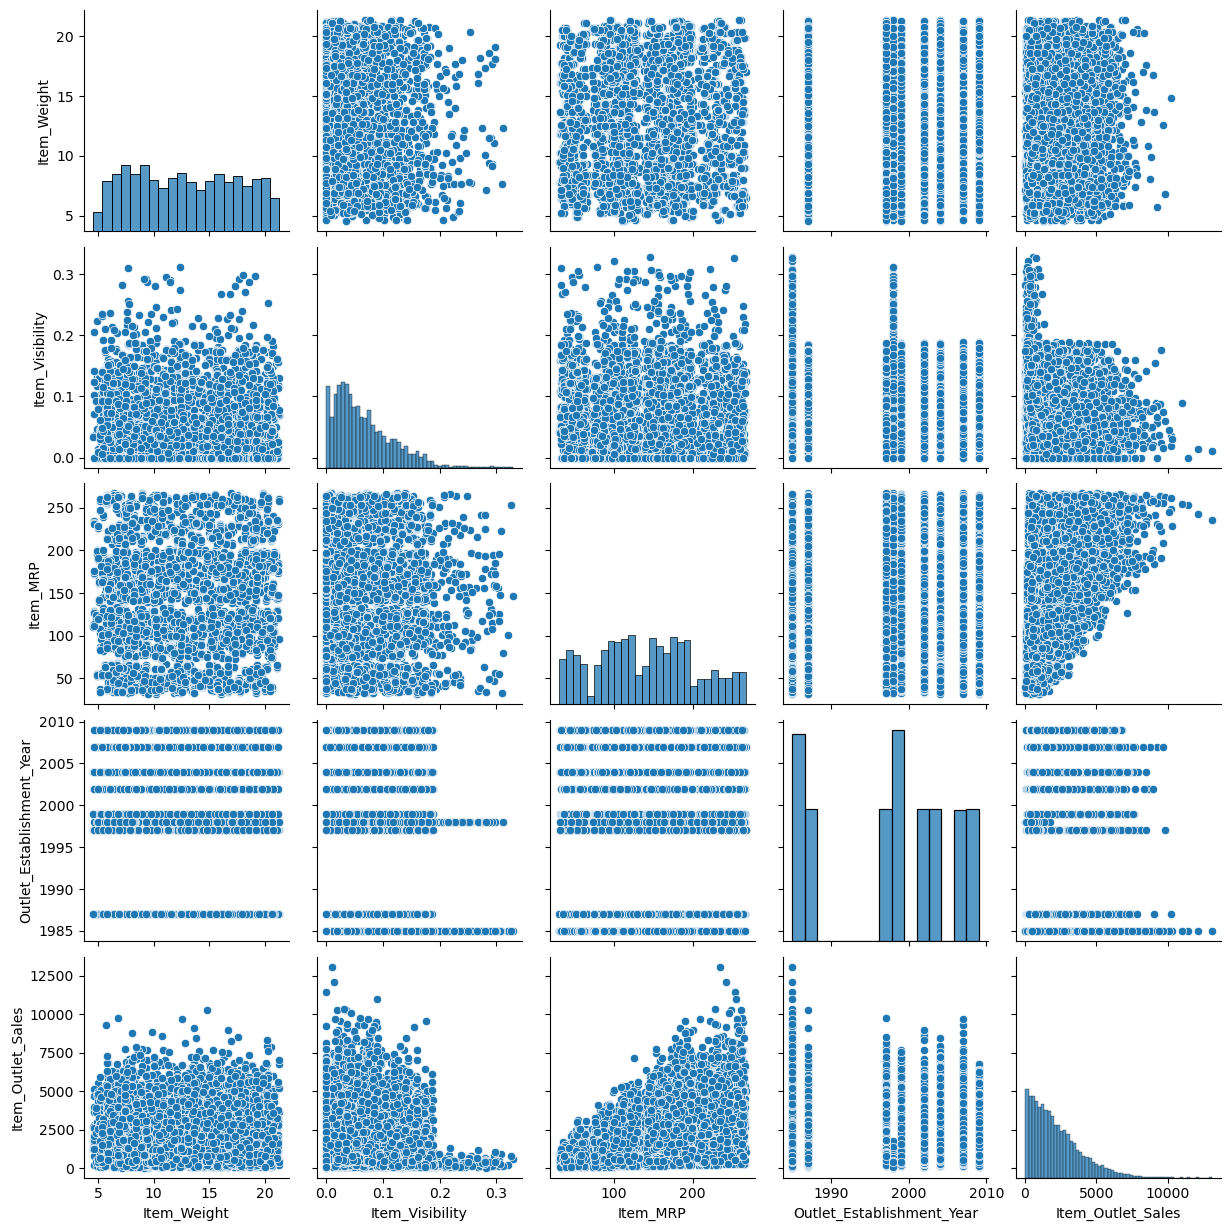

In [105]:
sns.pairplot(data_train)

**pair plot to demonstrate the relationship of all entities with each other and all features with the target   
and because there are no linear relationships between sales except at MRP, it is assumed that the linear regression model will not operate well.**

In [106]:
def draw_boxplot(colname):
    return sns.boxplot(data_train[colname])

Item_Weight Boxplot:


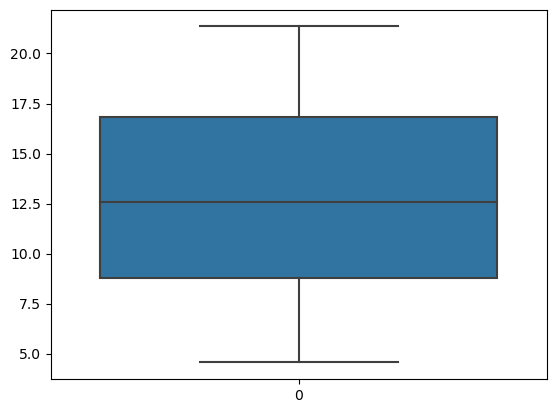

Item_Visibility Boxplot:


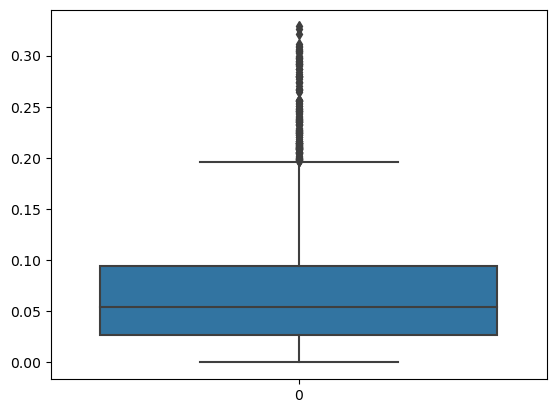

Item_MRP Boxplot:


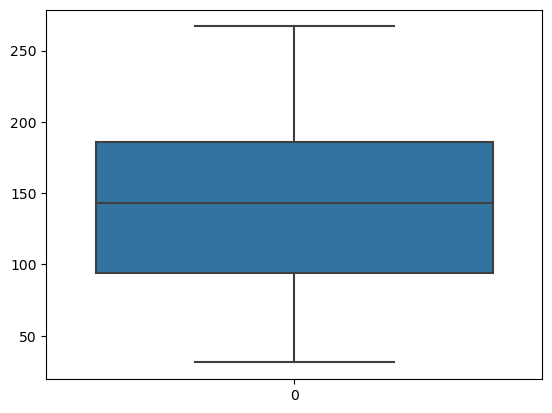

Item_Outlet_Sales Boxplot:


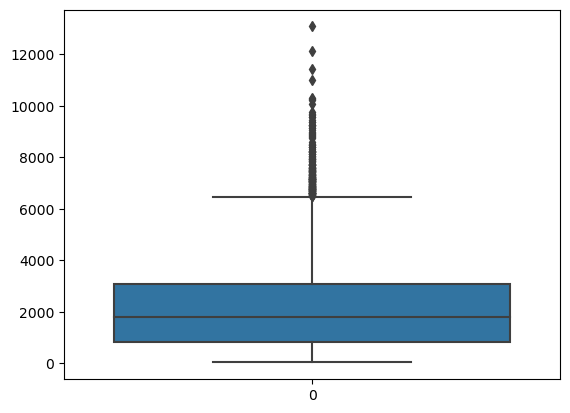

In [107]:
for col in data_train.columns:
    if data_train[col].dtype == 'float64':
        print(col, 'Boxplot:')
        ax = draw_boxplot(col)
        plt.show()
    else:
        pass

**No outliers in:** \
1.itemweight \
2.Item_MRP \
**Outliers in:** \
1.Item_Visibility \
2.Item_Outlet_Sales


**The box plot demonstrates that there are outliers in sales, but it does not add noise to the data because sales vary depending on the product category**

In [108]:
def handle_outlier(col):
    '''
    Function that gets maximumn and minimum values for provided column
    
    Args: column name
    
    Reuturns: The max and min values of that column
    '''
    sorted(col)
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower=Q1-(1.5*IQR)
    upper=Q3+(1.5*IQR)
    return lower , upper

In [109]:
# Get max and minimum values
minimum_visibility,maximum_visibility = handle_outlier(data_train['Item_Visibility'])

In [110]:
# Replace values above max by maximum values and values below minimum by minimum values
data_train['Item_Visibility']=np.where(data_train['Item_Visibility']>maximum_visibility,maximum_visibility,data_train['Item_Visibility'])
data_train['Item_Visibility']=np.where(data_train['Item_Visibility']<minimum_visibility,minimum_visibility,data_train['Item_Visibility'])

<Axes: >

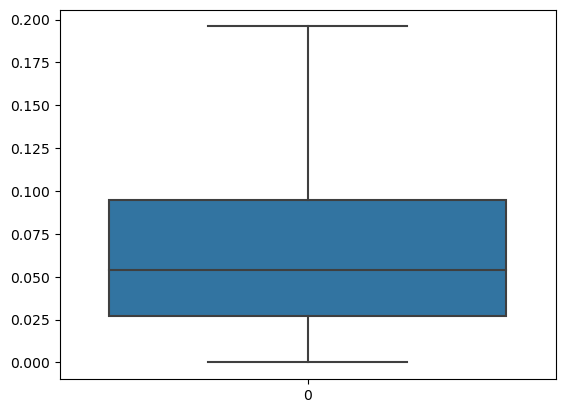

In [111]:
# After handling outliers
draw_boxplot('Item_Visibility')

## 4. EDA - Univariate

In [112]:
data_train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.065307,140.992782,1997.831867,2181.288914
std,4.643456,0.048841,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.195979,266.888400,2009.000000,13086.964800


In [113]:
# Replace abbreviations with the right words to improve data clarity.
data_train['Item_Fat_Content']=data_train['Item_Fat_Content'].replace('LF','Low Fat')
data_train['Item_Fat_Content']=data_train['Item_Fat_Content'].replace('low fat','Low Fat')
data_train['Item_Fat_Content']=data_train['Item_Fat_Content'].replace('reg','Regular')

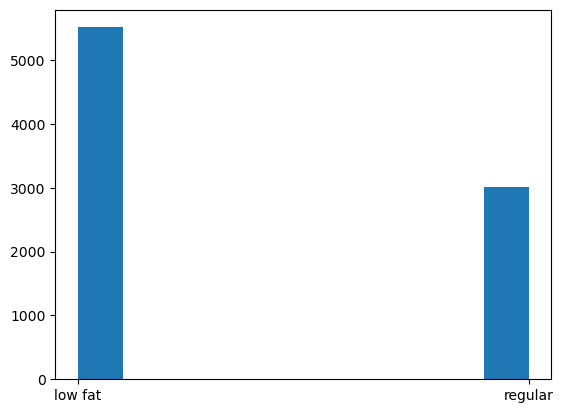

In [114]:
plt.hist((data_train['Item_Fat_Content']).str.lower())
plt.show()

**Most of the data reveal low fat items, which might possibly imply that the target clients are passionate about wellness** 

In [115]:
Counter(data_train['Item_Type'])

Counter({'Dairy': 682,
         'Soft Drinks': 445,
         'Meat': 425,
         'Fruits and Vegetables': 1232,
         'Household': 910,
         'Baking Goods': 648,
         'Snack Foods': 1200,
         'Frozen Foods': 856,
         'Breakfast': 110,
         'Health and Hygiene': 520,
         'Hard Drinks': 214,
         'Canned': 649,
         'Breads': 251,
         'Starchy Foods': 148,
         'Others': 169,
         'Seafood': 64})

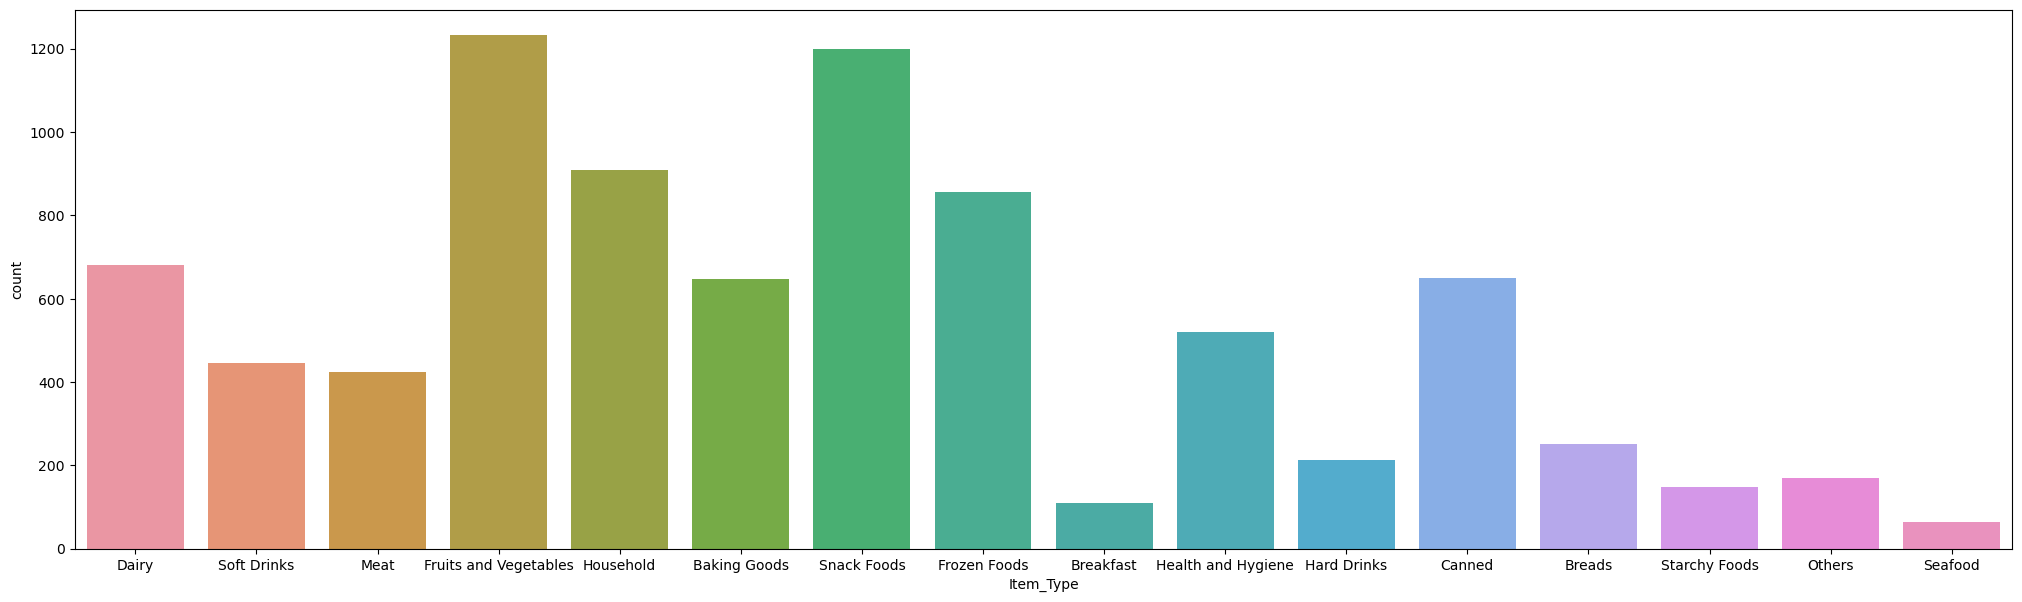

In [116]:
# Item_Type column
plt.figure(figsize=(25,7))
sns.countplot(x='Item_Type', data=data_train)
plt.show()

**High-stock products :**
That could mean these products could be bestsellers if the stores have high quantity of
1. Fruits and Vegetables
2. Snack Food
3. House Hold
4. Frozen Foods

Based on the previous assumption, having Fruits and Vegetables in higher quantities which may indictate that target audience maybe indeed health enthusiasts

/var/folders/7j/bl20_c316hs94pdnkbkjqmkr0000gn/T/ipykernel_52831/3686016041.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data_train['Item_MRP'])


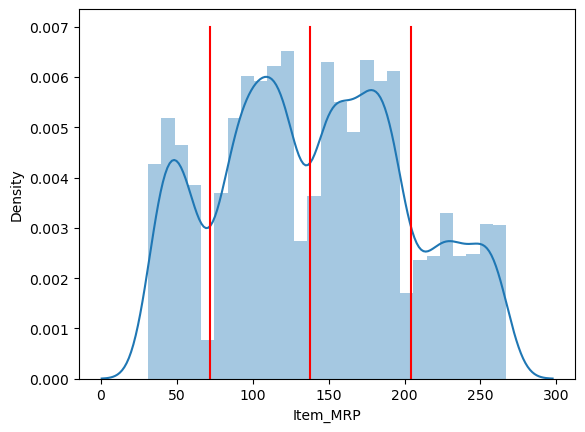

In [117]:
# create a histogram of the Item_MRP variable
ax = sns.distplot(data_train['Item_MRP'])

# define the x-coordinates of the vertical lines
x1 = 72
x2 = 138
x3 = 204

# add vertical lines to the plot at the specified x-coordinates
ax.plot([x1, x1],[0, 0.007], color='r')
ax.plot([x2, x2],[0, 0.007], color='r')
ax.plot([x3, x3],[0, 0.007], color='r')

# display the plot
plt.show()

In [118]:
data_train['Item_MRP'].min()

31.29

In [119]:
data_train['Item_MRP'].max()

266.8884

**The Item_MRP clearly shows there are 4 different price categories** \  

**category 1:**  30 ~ 70 \
**category 2:**  70 ~ 140 \
**category 3:**  140 ~ 200 \
**category 4:**  200 ~ 270 

lowest-price : 31.29 \
Highest-price : 266.8884

In [120]:
tier_type = Counter(data_train['Outlet_Location_Type']).keys()
tier_count = Counter(data_train['Outlet_Location_Type']).values()

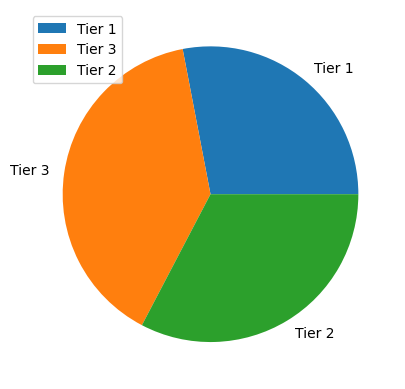

In [121]:
plt.pie(tier_count,labels = tier_type)
plt.legend()
plt.show()

Cities classified into Tier 1, 2 and 3 categories. \
The most developed ones are called tier 1 and the underdeveloped ones are called tier 2 and tier 3 cities

High amounts of product in \
**Tier 2 and Tier 3 areas**

In [122]:
Counter(data_train['Outlet_Size'])

Counter({'Medium': 2793, nan: 2410, 'High': 932, 'Small': 2388})

In [123]:
size_type = Counter(data_train['Outlet_Size']).keys()
size_count = Counter(data_train['Outlet_Size']).values()

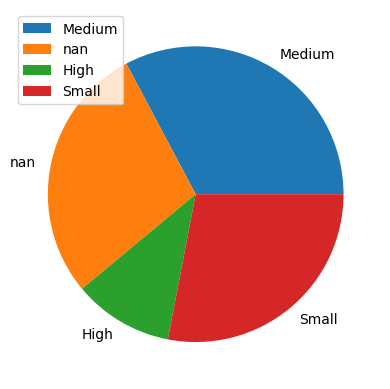

In [124]:
plt.pie(size_count,labels = size_type)
plt.legend()
plt.show()

**Most stores are medium or small in size, and we have a lot of nulls,\
we don't know for sure if the high is merely a small percentage of the total.**

## 5. EDA - Bivariate

In [125]:
data = data_train.pivot(columns='Outlet_Location_Type', values='Outlet_Size')

In [126]:
for col in data.columns:
    print('Location Type : ' , col)
    print(data[col].value_counts())
    print()

Location Type :  Tier 1
Small     1458
Medium     930
Name: Tier 1, dtype: int64

Location Type :  Tier 2
Small    930
Name: Tier 2, dtype: int64

Location Type :  Tier 3
Medium    1863
High       932
Name: Tier 3, dtype: int64



In [127]:
Location_Size = {'Types': ['Tier 1', 'Tier 2', 'Tier 3'],
                 'Small': [1458, 930, 0],
                 'Medium': [930, 0, 1863],
                 'High': [0, 0, 932]
                }

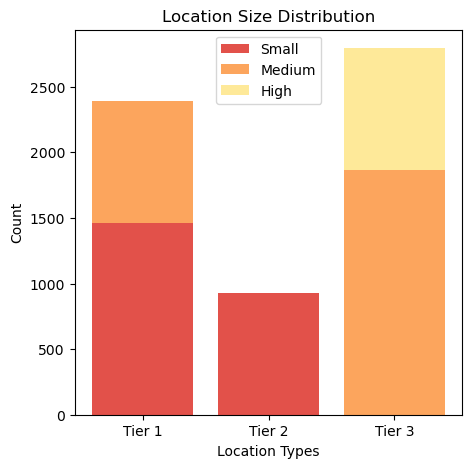

In [128]:
# Set the size of the figure
plt.figure(figsize=(5, 5))

# Define the colors using the flare palette
colors = sns.color_palette("Spectral")

# Plot the stacked bar chart with the specified colors
plt.bar(Location_Size['Types'], Location_Size['Small'], color=colors[0], label='Small')
plt.bar(Location_Size['Types'], Location_Size['Medium'], bottom=Location_Size['Small'], color=colors[1], label='Medium')
plt.bar(Location_Size['Types'], Location_Size['High'], bottom=[i+j for i, j in zip(Location_Size['Small'], Location_Size['Medium'])], color=colors[2], label='High')

# Add labels and title
plt.xlabel('Location Types')
plt.ylabel('Count')
plt.title('Location Size Distribution')

# Add legend
plt.legend()

# Show the plot
plt.show()

**In Tier 3 cities have the highest number of medium sized stores followed by Tier 1 and there are none in Tier 2**

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

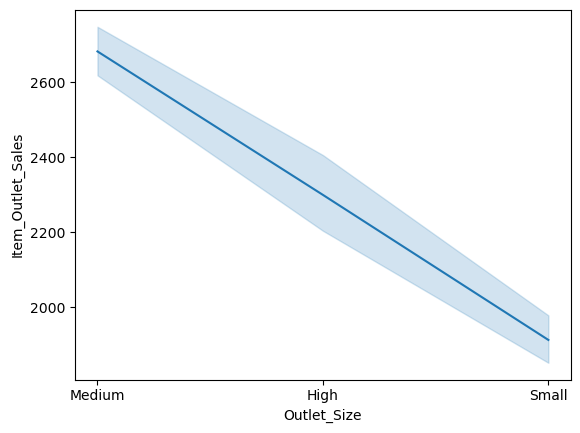

In [129]:
sns.lineplot(data=data_train, x="Outlet_Size", y="Item_Outlet_Sales")

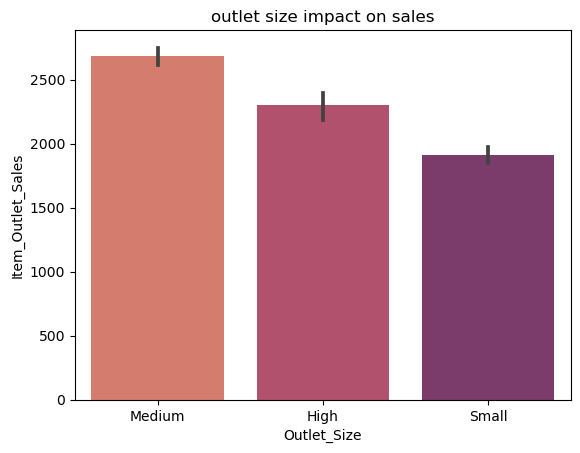

In [130]:
sns.barplot(data=data_train, x="Outlet_Size", y='Item_Outlet_Sales',palette ="flare")
plt.title('outlet size impact on sales')
plt.show()

**From that barplot we can deduct that medium sized stores have the best sales followed by larger stores  
Small stores have the least**

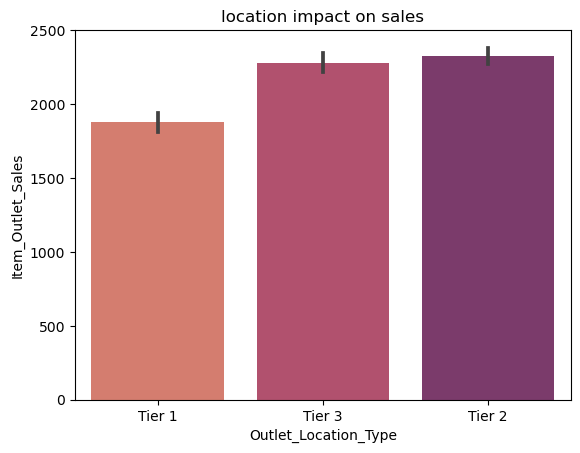

In [131]:
sns.barplot(data=data_train, x="Outlet_Location_Type", y='Item_Outlet_Sales',palette ="flare")
plt.title('location impact on sales')
plt.show()

**Surprisingly, the strongest sales come from tier 2, despite our expectation that smaller stores have a negative influence on sales, which is not the case because tier 2 only has small sized stores, closely followed by tier 3, 
and the least from tier 1 nans has an impact on data**

In [132]:
data2 = data_train.pivot(columns='Outlet_Location_Type', values='Item_Type')

In [133]:
for col in data2.columns:
    print('Location Type : ' , col)
    print(data[col].value_counts())
    print()

Location Type :  Tier 1
Small     1458
Medium     930
Name: Tier 1, dtype: int64

Location Type :  Tier 2
Small    930
Name: Tier 2, dtype: int64

Location Type :  Tier 3
Medium    1863
High       932
Name: Tier 3, dtype: int64



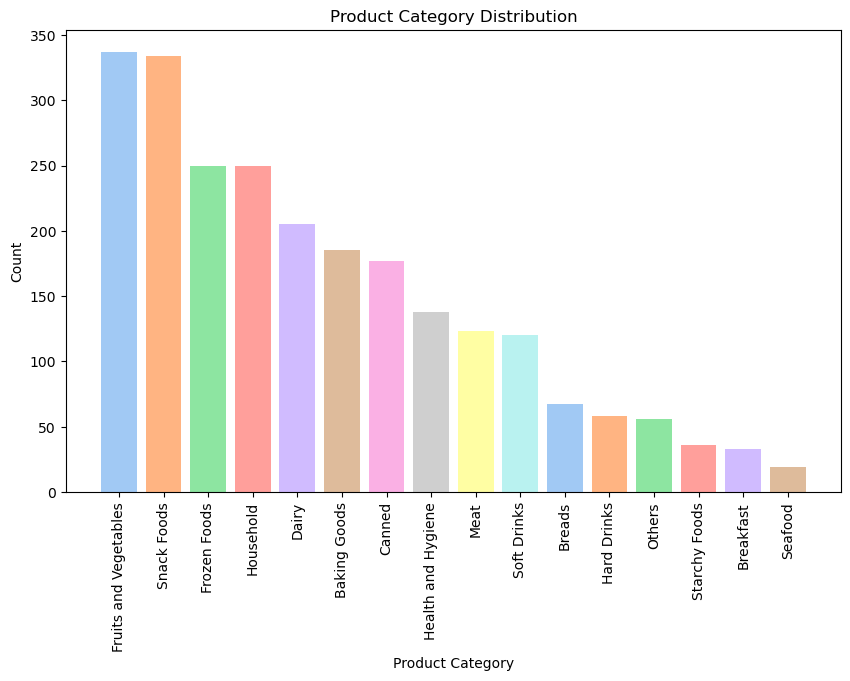

In [134]:

Tier1_data = {
    'Product_Category': ['Fruits and Vegetables', 'Snack Foods', 'Frozen Foods', 'Household', 'Dairy', 'Baking Goods', 'Canned', 'Health and Hygiene', 'Meat', 'Soft Drinks', 'Breads', 'Hard Drinks', 'Others', 'Starchy Foods', 'Breakfast', 'Seafood'],
    'Count': [337, 334, 250, 250, 205, 185, 177, 138, 123, 120, 67, 58, 56, 36, 33, 19]
}

# Set the size of the figure
plt.figure(figsize=(10, 6))
colors = sns.color_palette("pastel")


# Plot the bar chart
plt.bar(Tier1_data['Product_Category'], Tier1_data['Count'],color = colors)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.title('Product Category Distribution')

# Show the plot
plt.show()

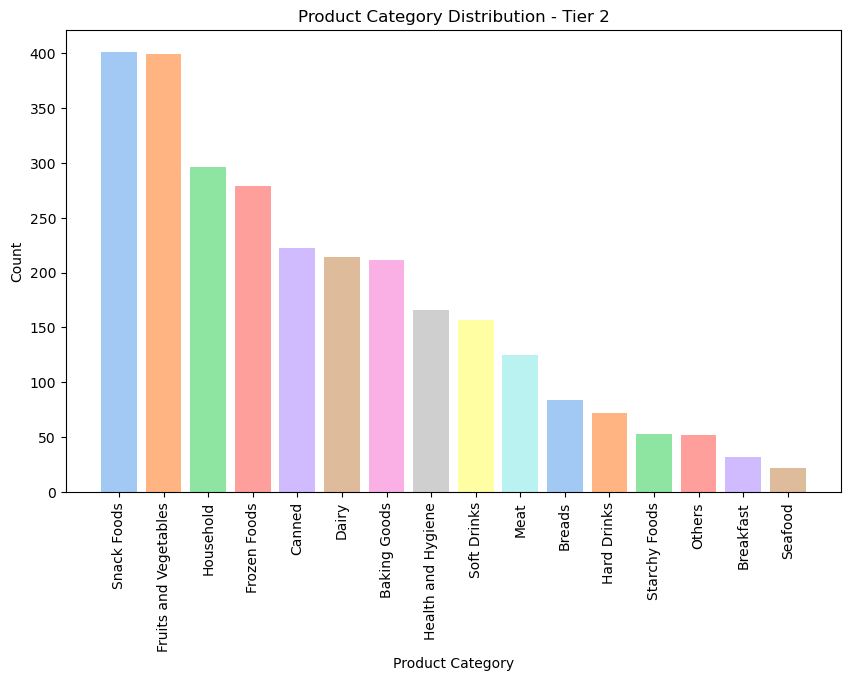

In [135]:
tier2_data = {
    'Product_Category': ['Snack Foods', 'Fruits and Vegetables', 'Household', 'Frozen Foods', 'Canned', 'Dairy', 'Baking Goods', 'Health and Hygiene', 'Soft Drinks', 'Meat', 'Breads', 'Hard Drinks', 'Starchy Foods', 'Others', 'Breakfast', 'Seafood'],
    'Count': [401, 399, 296, 279, 222, 214, 211, 166, 157, 125, 84, 72, 53, 52, 32, 22]
}

# Set the size of the figure
plt.figure(figsize=(10, 6))

colors = sns.color_palette("pastel")

# Plot the bar chart
plt.bar(tier2_data['Product_Category'], tier2_data['Count'], color = colors)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.title('Product Category Distribution - Tier 2')

# Show the plot
plt.show()

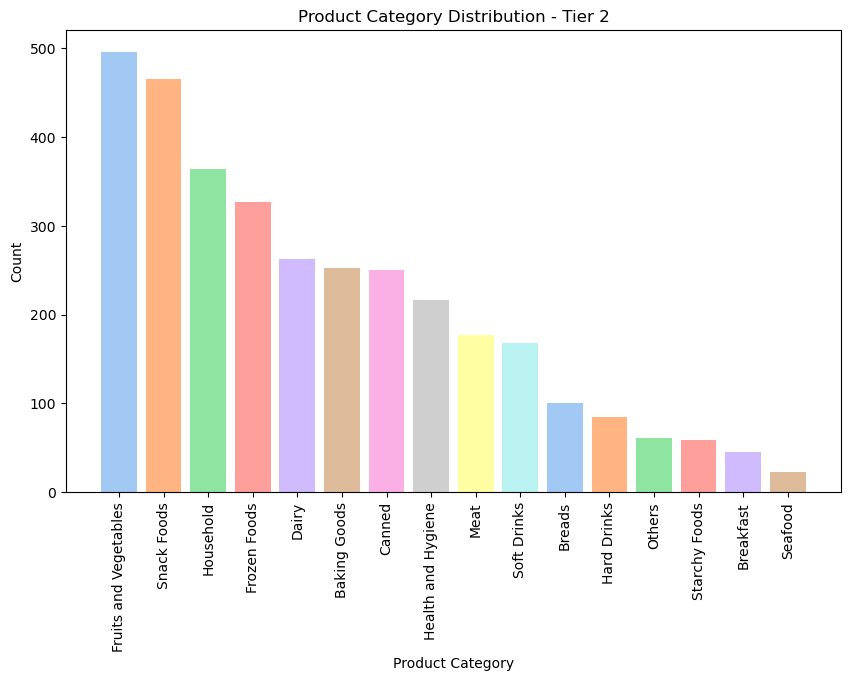

In [136]:
tier3_data = {
    'Product_Category': ['Fruits and Vegetables', 'Snack Foods', 'Household', 'Frozen Foods', 'Dairy', 'Baking Goods', 'Canned', 'Health and Hygiene', 'Meat', 'Soft Drinks', 'Breads', 'Hard Drinks', 'Others', 'Starchy Foods', 'Breakfast', 'Seafood'],
    'Count': [496, 465, 364, 327, 263, 252, 250, 216, 177, 168, 100, 84, 61, 59, 45, 23]
}


# Set the size of the figure
plt.figure(figsize=(10, 6))

colors = sns.color_palette("pastel")

# Plot the bar chart
plt.bar(tier3_data['Product_Category'], tier3_data['Count'], color = colors)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.title('Product Category Distribution - Tier 2')

# Show the plot
plt.show()

**Here we can see that the best sellers are fruits and vegetables, which may support our claim that the target clients are mostly health enthusiasts and that it would be better if the store invested in healthier products, as well as snacks and household items, which may also be a good idea to invest more in
ex keto**

In [137]:
data_train.groupby(['Item_MRP']).mean()['Item_Visibility'].sort_values().dropna().to_dict()


/var/folders/7j/bl20_c316hs94pdnkbkjqmkr0000gn/T/ipykernel_52831/1541330839.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_train.groupby(['Item_MRP']).mean()['Item_Visibility'].sort_values().dropna().to_dict()


{115.0834: 0.0,
 45.5402: 0.0,
 114.686: 0.0,
 162.3578: 0.0,
 228.8668: 0.0,
 162.0578: 0.0,
 109.1254: 0.0,
 87.3882: 0.0,
 45.2402: 0.0,
 229.201: 0.0,
 230.0668: 0.0,
 88.054: 0.0,
 159.6604: 0.0,
 159.3262: 0.0,
 44.1428: 0.0,
 44.1086: 0.0,
 232.7326: 0.0,
 109.1938: 0.0,
 234.7958: 0.0,
 235.6248: 0.0,
 87.1856: 0.0,
 43.4744: 0.0,
 45.7428: 0.0,
 227.4694: 0.0,
 217.6166: 0.0,
 84.554: 0.0,
 47.8034: 0.0,
 84.5908: 0.0,
 219.4456: 0.0,
 84.654: 0.0,
 115.2176: 0.0,
 220.4798: 0.0,
 47.2744: 0.0,
 220.7482: 0.0,
 164.721: 0.0,
 224.1062: 0.0,
 46.5402: 0.0,
 46.5376: 0.0,
 115.0176: 0.0,
 225.1088: 0.0,
 164.2184: 0.0,
 46.006: 0.0,
 45.9402: 0.0,
 227.5694: 0.0,
 83.7566: 0.0,
 157.7972: 0.0,
 89.4146: 0.0,
 40.8822: 0.0,
 91.8488: 0.0,
 40.7138: 0.0,
 102.999: 0.0,
 125.9362: 0.0,
 92.312: 0.0,
 242.3538: 0.0,
 102.9016: 0.0,
 92.9462: 0.0,
 244.1828: 0.0,
 93.1462: 0.0,
 244.2512: 0.0,
 150.3024: 0.0,
 244.817: 0.0,
 245.0144: 0.0,
 149.8024: 0.0,
 149.4734: 0.0,
 245.2118: 0

**We can see visibility has nothing to do with price**

/Users/sherywalid/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


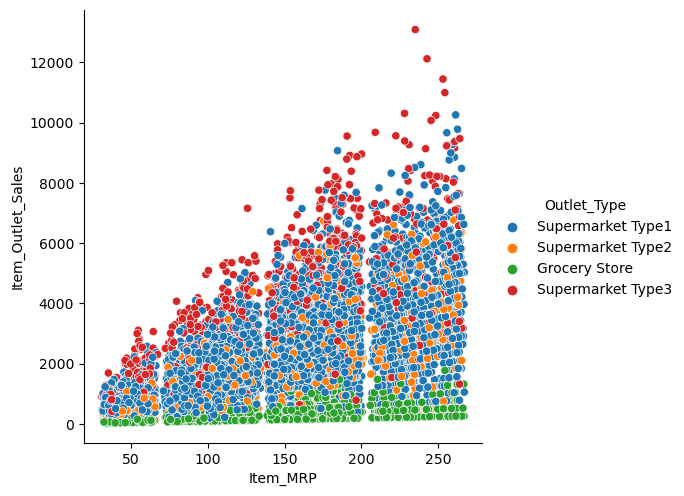

In [138]:
sns.pairplot(data=data_train, x_vars='Item_MRP', y_vars='Item_Outlet_Sales', hue='Outlet_Type', size=5)

/Users/sherywalid/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


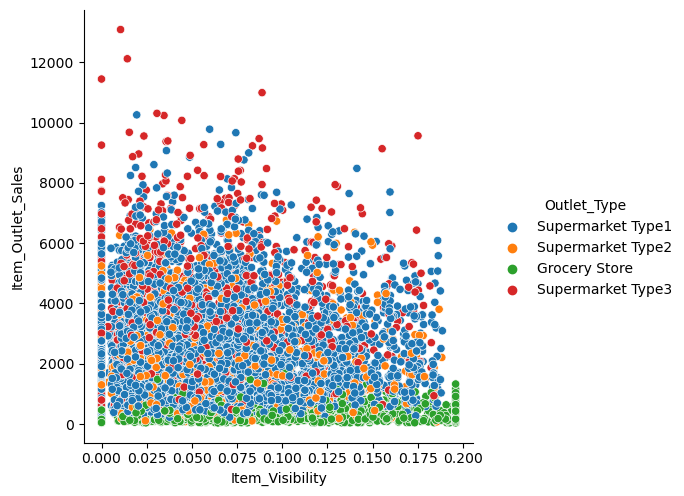

In [139]:
sns.pairplot(data=data_train, x_vars='Item_Visibility', y_vars='Item_Outlet_Sales', hue='Outlet_Type', size=5)


**There is a positive correlation between Item_MRP and Item_Outlet_Sales  
A negative correlation between Item_Outlet_Sales and visibility**

## 6. Data preprocessing

1. Check nulls
2. Check duplicates
3. Encode the data
4. Scale data

**Train data**

In [140]:
# Check for nulls
data_train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [141]:
data_train['Item_Weight'].fillna(data_train['Item_Weight'].mean(),inplace = True)

In [142]:
data_train['Outlet_Size'].fillna(method="bfill",inplace = True)

In [143]:
# Data has no duplicates
data_train.duplicated().sum()

0

In [144]:
# Encode categorical data to numerical
label_encoder = preprocessing.LabelEncoder()

In [145]:
for col in data_train.columns:
    if data_train[col].dtype != 'float64':
        data_train[col]= label_encoder.fit_transform(data_train[col])
    else:
        pass

In [146]:
# Initialize the StandardScaler
scaler = StandardScaler()

In [147]:
for col in data_train.columns:
    if data_train[col].dtype != 'object':  # Check if column is numeric
        data_train[col] = scaler.fit_transform(data_train[col].values.reshape(-1, 1))

In [148]:
data_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,-1.388514,-0.841872,-0.738147,-1.008628,-0.766479,1.747454,1.507813,0.076668,-0.337204,-1.369334,-0.252658,0.910601
1,-1.717991,-1.641706,1.354743,-0.942473,1.608963,-1.489023,-0.607071,1.541783,-0.337204,1.091569,1.002972,-1.018440
2,-0.262057,1.098554,-0.738147,-0.994034,0.658786,0.010040,1.507813,0.076668,-0.337204,-1.369334,-0.252658,-0.049238
3,0.759769,1.500838,1.354743,-1.337208,-0.291391,0.660050,-1.664513,-0.289611,-1.776356,1.091569,-1.508289,-0.849103
4,1.151580,-0.929428,-0.738147,-1.337208,0.421242,-1.399220,-1.312032,-1.022168,-1.776356,1.091569,-0.252658,-0.695373


**Test data**

In [187]:
# Check for nulls
data_test.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [188]:
data_test['Item_Weight'].fillna(data_test['Item_Weight'].mean(),inplace = True)
data_test['Outlet_Size'].fillna(method="bfill",inplace = True)

In [189]:
# Data has no duplicates
data_test.duplicated().sum()


0

In [190]:
# Encode categorical data to numerical
for col in data_test.columns:
    if data_test[col].dtype != 'float64':
        data_test[col]= label_encoder.fit_transform(data_test[col])
    else:
        pass

In [191]:
for col in data_test.columns:
    if data_test[col].dtype != 'object':  # Check if column is numeric
        data_test[col] = scaler.fit_transform(data_test[col].values.reshape(-1, 1))

In [192]:
data_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0.739896,1.897460e+00,-0.575284,-1.134077,1.366916,-0.536555,1.507689,0.077048,-0.33686,-1.369215,-0.252769
1,0.659085,-1.035530e+00,4.104698,-0.531850,-0.766450,-0.868937,-0.959749,1.175901,-0.33686,-0.138827,-0.252769
2,1.420050,4.486336e-01,-0.575284,0.661316,0.892835,1.629848,-1.664731,-0.289236,-0.33686,1.091560,-1.507994
3,0.079943,-1.267578e+00,-0.575284,-0.981416,1.366916,0.226697,-0.959749,1.175901,-0.33686,-0.138827,-0.252769
4,0.921719,1.574004e-17,0.984710,1.032540,-0.766450,1.508110,0.097725,-1.388089,-0.33686,1.091560,2.257683


## 7. Modeling
**1. Building and Training \
2. Testing    
3. Evaluate  
4. Save the model**

### 1. Linear Regression

In [150]:
# split train data to data_matrix and label_vector
x = data_train.drop(['Item_Outlet_Sales'],axis = 1)
y = data_train['Item_Outlet_Sales']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 42)

In [151]:
# intialize linear regression model
Linear = LinearRegression()

# train model
Linear.fit(x_train,y_train)

# test model
y_predict = Linear.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("R-squared test:", r2)

R-squared test: 0.5114155634752777


In [152]:
# accuracy_score is for classification tasks only
Linear.score(x_test,y_test)*100

51.0271193141933

In [153]:
# Save the model
joblib.dump(Linear, 'Linear_model.h5')

['Linear_model.h5']

L1 regularisation, such as Lasso regression, can assist enhance your model's efficiency by decreasing overfitting and choosing important features. L1 regularisation promotes sparsity in model coefficients, allowing it to execute feature selection automatically by decreasing irrelevant or less significant features to zero.

In [154]:
# intialize linear regression model using L1 regularization and train model
lasso_reg = linear_model.Lasso(alpha=0.001, max_iter=100, tol=0.0001)
lasso_reg.fit(x_train, y_train)

# test model
y_pred = lasso_reg.predict(x_test)

In [155]:
lasso_reg.score(x_test,y_test)*100

51.06101276851488

**Almost the same score, however linear regression has low accuracy, as demonstrated by the pair plot, which shows that there are no linear correlations between features and the predicted target.**

### 2. XGB

Because the scores are similar then the model is neither under or over fitting, 
but to improve feature efficiency and score, \
we can use **XGB**

In [156]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=1, eta=0.2, subsample=0.7, colsample_bytree=0.5,seed = 42)

# Train the model
xgb_model.fit(x_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(x_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.5628841246277365


In [157]:
xgb_model.score(x_test,y_test)*100

56.28841246277365

In [158]:
# Save the model
joblib.dump(xgb_model, 'xgb_model.h5')

['xgb_model.h5']

### 3. GBR

It improved the score with 5% still not good but relatively better  \
but we can also try **GBR**

In [159]:
#Define the GBR model
gbr_model = GradientBoostingRegressor(n_estimators=100, max_depth=1, learning_rate=0.1, min_samples_split=2, random_state=42)

# Train the model
gbr_model.fit(x_train, y_train)

#Predict and evaluate
y_pred = gbr_model.predict(x_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.568146839071848


In [160]:
gbr_model.score(x_test,y_test)*100

56.8146839071848

In [161]:
# Save the model
joblib.dump(gbr_model, 'gbr_model.h5')

['gbr_model.h5']

### 4. Random Forest Regressor

In [162]:
regressor = RandomForestRegressor(n_estimators=200, random_state=42)
regressor.fit(x_train, y_train)

y_pred = regressor.predict(x_test)
clf_r2 = r2_score(y_test, y_pred)

print("R2 Score:", clf_r2*100)

R2 Score: 55.3159751306874


In [163]:
# regressor.score(y_test)
regressor.score(x_test,y_test)*100

55.3159751306874

In [164]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 

print("RMSE: %f" % (rmse))

RMSE: 0.655619


The RMSE calculates the average gap between predicted and actual values.  
A smaller RMSE shows that the model's predictions are, on average, closer to the actual values.  
**This indicates that the model accurately captures the underlying patterns and connections in the data.**

In [165]:
# Save the model
joblib.dump(regressor, 'regressor_model.h5')

['regressor_model.h5']

**Use On Test data**

In [172]:
linear_test = Linear.predict(data_test)
xgb_test = xgb_model.predict(data_test)
gbr_test = gbr_model.predict(data_test) 
random_forest_test = regressor.predict(data_test) 

In [173]:
linear_test = pd.DataFrame(linear_test)
testdata_with_linearReg = pd.concat([data_test, linear_test], axis=1)

rf = pd.DataFrame(random_forest_test)
testdata_with_rf = pd.concat([data_test, rf], axis=1)

xgboost = pd.DataFrame(xgb_test)
testdata_with_xgb = pd.concat([data_test, xgboost], axis=1)

gbr_data = pd.DataFrame(gbr_test)
testdata_with_gbr = pd.concat([data_test, gbr_data], axis=1)

In [183]:
# rename column sales
testdata_with_xgb.rename(columns = {0:'sales'}, inplace = True)
testdata_with_linearReg.rename(columns = {0:'sales'}, inplace = True)
testdata_with_rf.rename(columns = {0:'sales'}, inplace = True)
testdata_with_gbr.rename(columns = {0:'sales'}, inplace = True)

**These four dataframes contain the test data with prediction of sales with the different algorithms used**

### 9. Conclusion

**Sales are affected by more than one feature, which are classified as item data and stock data, and these features affect the target with varying percentages based on correlation and other factors. The data is not linearly related to each other, which makes a linear regression model a poor predictor. Hyper parameter tuning helps a lot in building good models, in particular the ***XGBoost Model***** 